In [216]:
# load style
from ROOT import gROOT

path = '/Users/yy/cernbox/'
# path = '/eos/user/y/youyou/'
gROOT.SetMacroPath(path+"atlasstyle/")
gROOT.LoadMacro("AtlasLabels.C")
gROOT.LoadMacro("AtlasStyle.C")
gROOT.LoadMacro("AtlasUtils.C")
from ROOT import SetAtlasStyle, ATLASLabel, myText, myMarkerText
SetAtlasStyle()


Applying ATLAS style settings...



In [217]:
# load lib
import ROOT
import numpy as np
# import pandas as pd


In [218]:
# load data

data_folder = './data/'
pulse = np.loadtxt(data_folder + 'pule_shape.txt')  # pulse shape
adc = np.loadtxt(data_folder + 'adc_out.txt')       # simulated adc output
signal = np.loadtxt(data_folder + 'signal.txt')     # delta func signal
pileup = np.loadtxt(data_folder + 'pileup.txt')     # pileup noise
wiener = np.loadtxt(data_folder + 'wiener_out.txt') # wiener filter output
of_coeff = np.loadtxt(data_folder + 'of_coeffs.txt')# optimal filter coefficients 
of_out = np.loadtxt(data_folder + 'of_out.txt')     # optimal filter output with above coeffs

plot_folder = './plots/'

# distribution of E_true

below is not correct for E_true

cuz i only plot distribution of delta func signal

In [ ]:
signal_none_zero = [i for i in signal if i != 0]

Mean of the histogram:  24.968571164961713
Standard devistion: 14.480601486996386
The range containing 98% of entries: (0.45679009000000004, 49.504818889999996)
Median of the range containing 98% of entries: 24.980804489999997


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


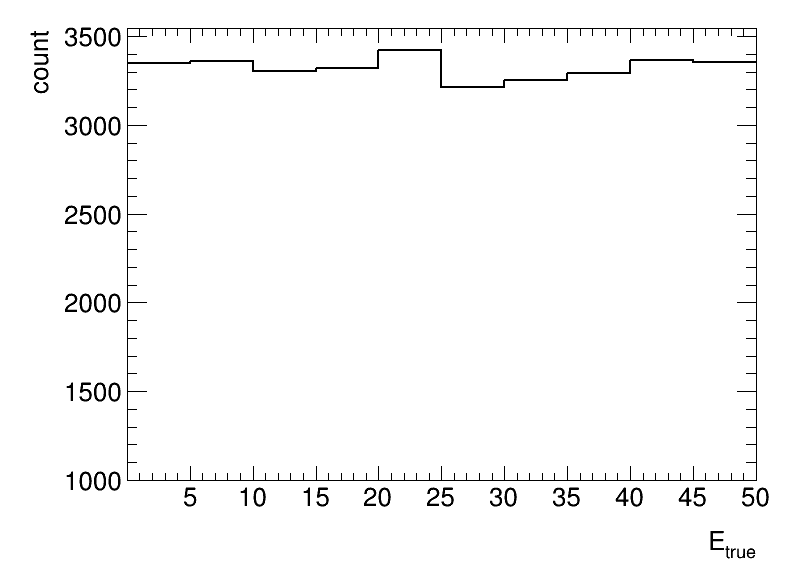

In [222]:
# above is not correct for E_true
# cuz i only plot distribution of delta func signal

signal_none_zero = [i for i in signal if i != 0]

canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)

# Create a TH1D histogram object with variable bin sizes
# if want to add 0 entries: bin_edges = [-3, 0.0001, 5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]
# if want to add 0 entries, remember to use log in y-axis
bin_edges = [0.0001, 5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]

num_bins = len(bin_edges) - 1
hist = ROOT.TH1D("hist", "Energy Distribution", num_bins, np.array(bin_edges, 'd'))

for i in signal:
    hist.Fill(i)

hist.SetMinimum(0)

hist.GetYaxis().SetTitle("count")
hist.GetXaxis().SetTitle("E_{true}")
hist.SetMinimum(1e3)

hist.Draw('hist')

canvas.SetLogy (0)
canvas.Update()
canvas.Draw()


print('Mean of the histogram: ', hist.GetMean())
print('Standard devistion:', hist.GetStdDev())
quantiles = np.percentile(signal_none_zero, 1),  np.percentile(signal_none_zero, 99)
print("The range containing 98% of entries:", (quantiles[0] , quantiles[1]))
print("Median of the range containing 98% of entries:", (quantiles[0] + quantiles[1]) / 2)

In [223]:
# there is a shift bwtn the given optimal filter output and adc
# generate residual btwn of output and E_true

of_new = of_out[5:]

e_diff_of = [i-j for i,j in zip(of_new, signal)]

## seperate into diff ranges of $E_{true}$ and analyze the distribution of $\Delta E$

In [ ]:

def find_position(x, arr):
    for i in range(len(arr)):
        if arr[i] > x:
            return i

In [225]:
# plotter that plot distribution for delta E with data points of E_true in a given range [start, end) 

def plot_signal_range(start, end, bins = np.linspace(-15, 25, 21), e_diff = e_diff_of):
    indexs = [i for i in range(len(signal)) if signal[i] > start and signal[i] <= end]
    data = [e_diff[i] for i in indexs]

    n_bins = len(bins)-1
    hist = ROOT.TH1D("hist", "Energy Distribution", n_bins, np.array(bins, 'd'))

    for i in data:
        hist.Fill(i)

    hist.GetYaxis().SetTitle("count")
    hist.GetXaxis().SetTitle("E_{reco}-E_{true}")

    # begin

    mean = hist.GetMean()
    std_dev = hist.GetStdDev()
    one_sigma_low = mean - std_dev
    one_sigma_high = mean + std_dev
    quantiles = np.percentile(data, 1),  np.percentile(data, 99)

    # median of 98%
    sorted_signal = np.sort(data)
    quantiles = np.percentile(sorted_signal, 1), np.percentile(sorted_signal, 99)
    filtered_signal = sorted_signal[(sorted_signal >= quantiles[0]) & (sorted_signal <= quantiles[1])]
    median = np.median(filtered_signal)


    line_arr = []
    bin_content = [hist.GetBinContent(i) for i in range(n_bins+1)]

    for i in [mean, one_sigma_low, one_sigma_high]:
        l = ROOT.TLine(i, 0, i, bin_content[find_position(i, bins)])
        l.SetLineStyle(ROOT.kDashed)
        l.SetLineColor(ROOT.kRed)
        line_arr += [l]
    for  j in [median, quantiles[0], quantiles[1]]:
        #print(j, '------')
        l = ROOT.TLine(j, 0, j, bin_content[find_position(j, bins)])
        l.SetLineStyle(ROOT.kDashed)
        l.SetLineColor(ROOT.kBlue)
        line_arr += [l]

    height = find_position(j, bins) 
    label_one_sigma = ROOT.TLatex(mean, height*1.2, "1 \sigma")
    label_one_sigma.SetTextAlign(12)
    label_one_sigma.SetTextSize(0.03)
    arrow_one_sigma_high = ROOT.TArrow(one_sigma_low, height, one_sigma_high, height, 0.02, "<>")
    arrow_one_sigma_high.SetLineColor(ROOT.kRed)

    height = height / 2.5
    label_98 = ROOT.TLatex(mean, height*1.2, "98% range")
    label_98.SetTextAlign(12)
    label_98.SetTextSize(0.03)
    arrow_98_low = ROOT.TArrow(quantiles[1], height, quantiles[0], height, 0.02, "<>")
    arrow_98_low.SetLineColor(ROOT.kBlue)
    line_arr += [label_one_sigma, arrow_one_sigma_high, label_98, arrow_98_low]

    print('==================================')
    print('Mean of the histogram: ', mean)
    print('Standard devistion:', std_dev)
    print("The range containing 98% of entries:", (quantiles[0] , quantiles[1]))
    print("Median of the range containing 98% of entries:", median)
    print('==================================')

    return hist, line_arr

    

Mean of the histogram:  -0.1272604847220155
Standard devistion: 0.8892799962137165
The range containing 98% of entries: (-1.8537757200000002, 2.279504520000001)
Median of the range containing 98% of entries: -0.21362799999999993


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


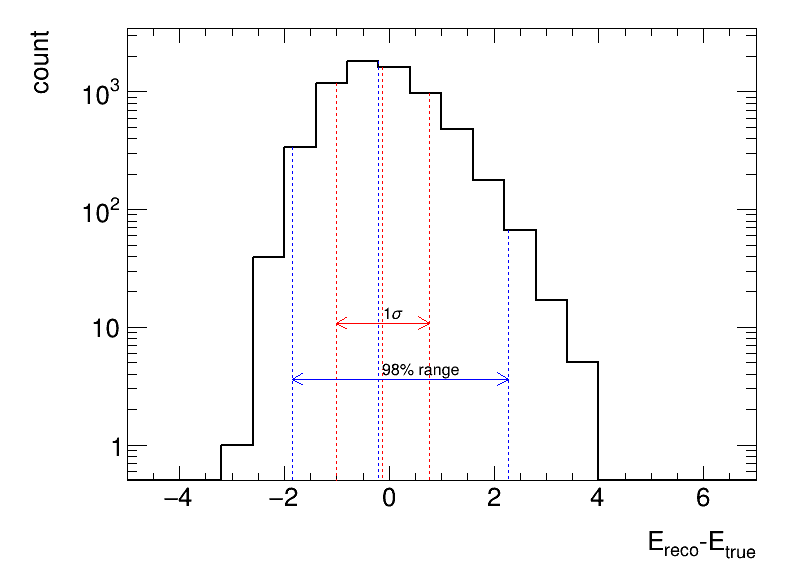

In [114]:
# call the function of E_true in [0, 10)

canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(0, 10, bins = np.linspace(-5, 7, 21), e_diff = e_diff_of)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

Mean of the histogram:  -0.2993976969651211
Standard devistion: 0.8805443426984089
The range containing 98% of entries: (-2.00572688, 2.136698279999999)
Median of the range containing 98% of entries: -0.3848830000000003


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


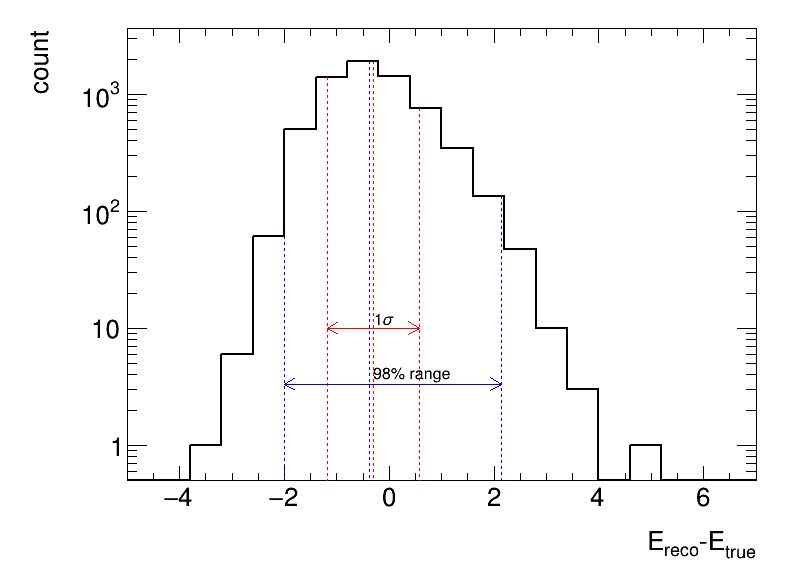

In [115]:
# call the function of E_true in [10, 20)

canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(10, 20, bins = np.linspace(-5, 7, 21), e_diff = e_diff_of)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

Mean of the histogram:  -0.4757204880216964
Standard devistion: 0.8941084298130623
The range containing 98% of entries: (-2.2051571200000017, 2.0636632799999983)
Median of the range containing 98% of entries: -0.553253999999999


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


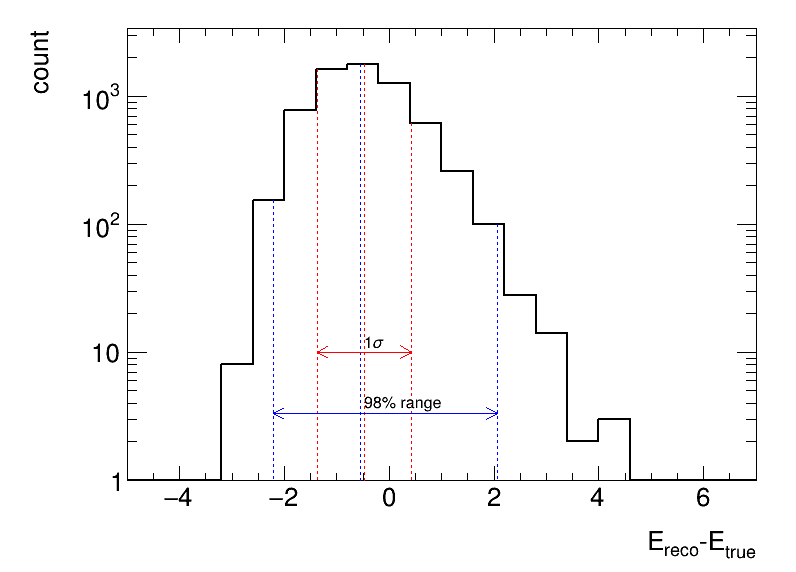

In [116]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(20, 30, bins = np.linspace(-5, 7, 21), e_diff = e_diff_of)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

Mean of the histogram:  -0.6518695627196361
Standard devistion: 0.8922462417612117
The range containing 98% of entries: (-2.385264199999999, 1.837838319999999)
Median of the range containing 98% of entries: -0.7427379999999992


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


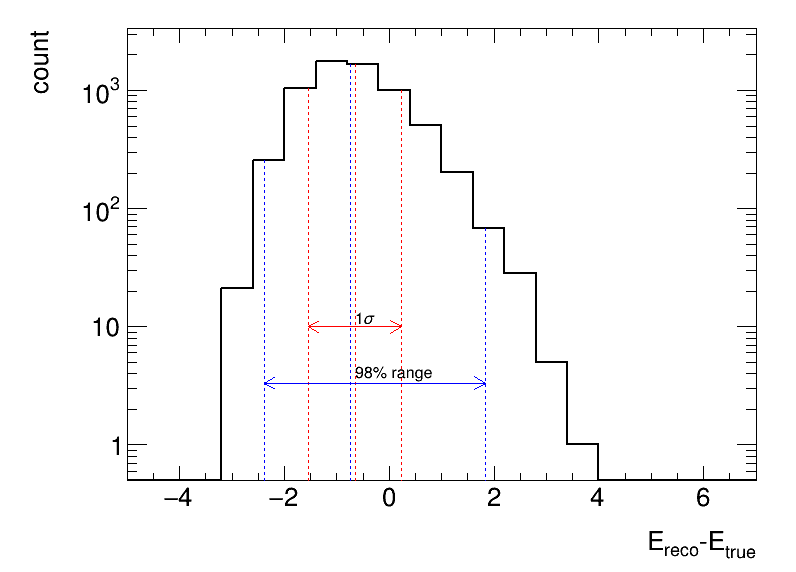

In [117]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(30, 40, bins = np.linspace(-5, 7, 21), e_diff = e_diff_of)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

Mean of the histogram:  -0.8301252328073849
Standard devistion: 0.879111236960588
The range containing 98% of entries: (-2.5138268999999984, 1.5949626299999964)
Median of the range containing 98% of entries: -0.9156895000000027


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


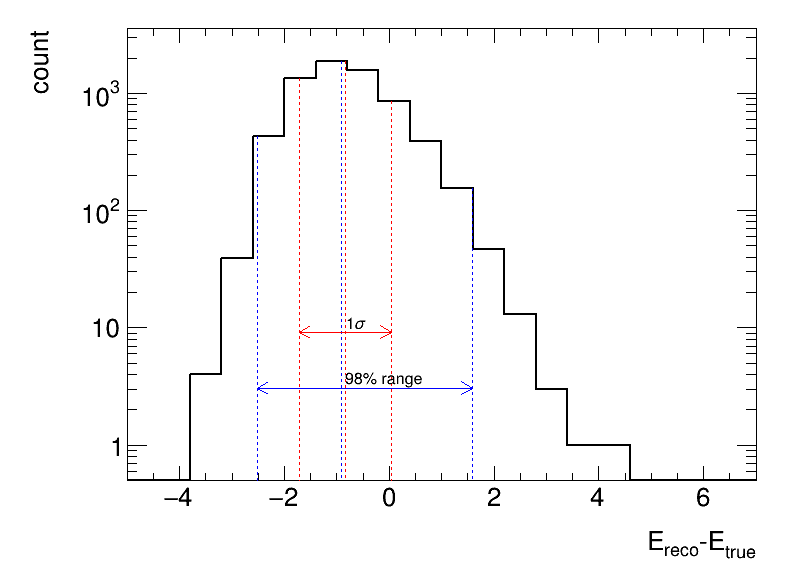

In [118]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(40, 50, bins = np.linspace(-5, 7, 21), e_diff = e_diff_of)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

## analyze the distribution of mean, std, 98% median within whole range of E_true

In [231]:
# calculate the mean, std, 98% median of the distributions


bins = np.linspace(0, 50, 11)
e_diff = e_diff_of
x, mean, std, median, lower_98, higher_98, indice = [], [], [], [], [], [], []


for j in range(len(bins)-1):
    x += [(bins[j] + bins[j+1])/2]
    indexs = [i for i in range(len(signal)) if signal[i] > bins[j] and signal[i] <= bins[j+1]]
    data = [e_diff[i] for i in indexs]
    indice += [len(indexs)]

    mean += [np.mean(data)]
    std += [np.std(data)]
    
    sorted_signal = np.sort(data)
    quantiles = np.percentile(sorted_signal, 1), np.percentile(sorted_signal, 99)
    filtered_signal = sorted_signal[(sorted_signal >= quantiles[0]) & (sorted_signal <= quantiles[1])]
    median += [np.median(filtered_signal)]
    lower_98 += [quantiles[0]]
    higher_98 += [quantiles[1]]

x_of, mean_of, std_of, median_of, lower_98_of, higher_98_of, indice_of = x, mean, std, median, lower_98, higher_98, indice

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


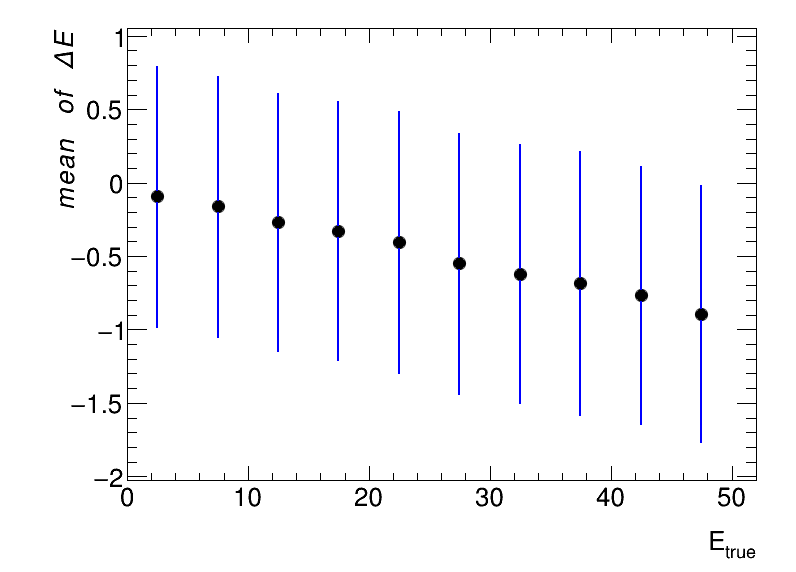

In [113]:
canvas = ROOT.TCanvas("canvas", "Graph Canvas", 800, 600)

x = x
y = mean
uncertainty_y = std

graph = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))

# Customize the graph appearance
graph.SetMarkerStyle(20)
graph.SetMarkerSize(1.5)
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)

# Set the axis titles
graph.GetXaxis().SetTitle("E_{true}")
graph.GetYaxis().SetTitle("mean\ of \overline{\Delta E}")
graph.GetYaxis().SetTitleOffset(1)

# Draw the graph
graph.Draw("AP")

# Update the canvas
canvas.Update()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


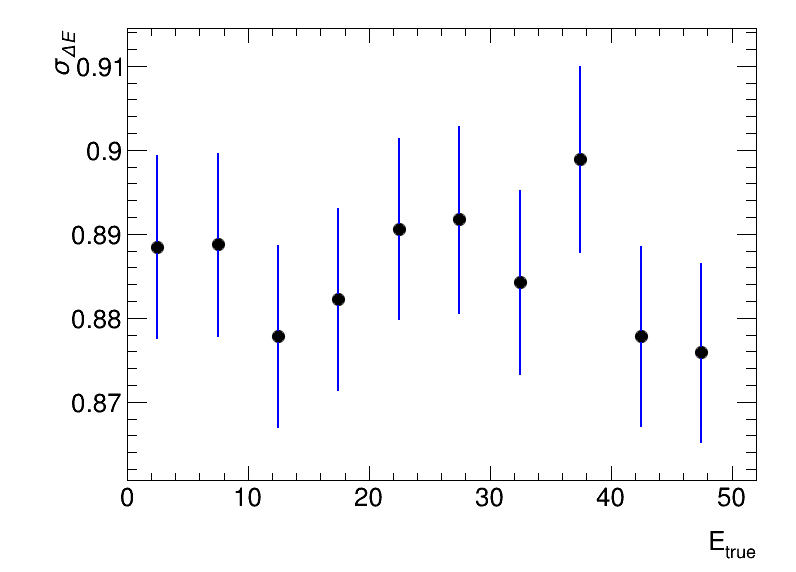

In [126]:
canvas = ROOT.TCanvas("canvas", "Graph Canvas", 800, 600)

x = x
y = np.array(std)
n = np.array(indice)
uncertainty_y = y / np.sqrt(2 * n-2)

graph = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))

# Customize the graph appearance
graph.SetMarkerStyle(20)
graph.SetMarkerSize(1.5)
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)

# Set the axis titles
graph.GetXaxis().SetTitle("E_{true}")
graph.GetYaxis().SetTitle("\sigma_{\Delta E}")
graph.GetYaxis().SetTitleOffset(1)

# Draw the graph
graph.Draw("AP")

# Update the canvas
canvas.Update()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


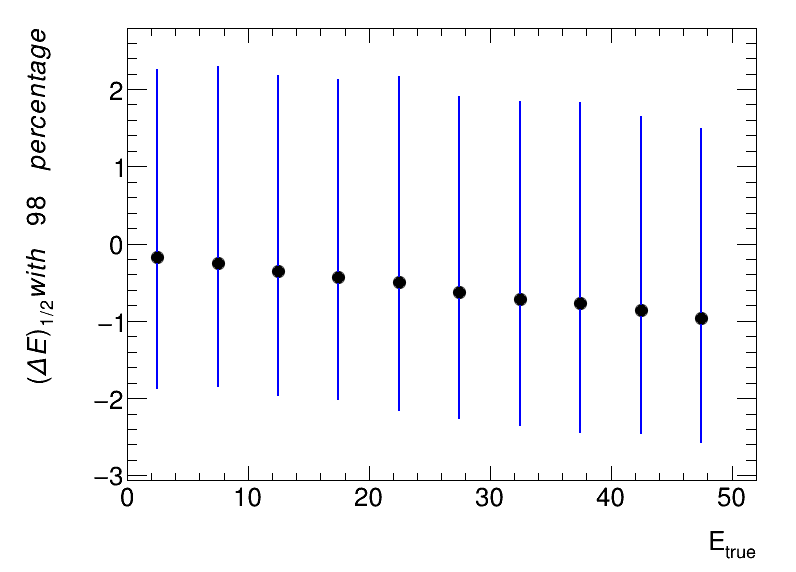

In [127]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)


x = np.array(x, 'd')
y = np.array(median, 'd')
lower_error = np.array(lower_98, 'd')  
upper_error = np.array(higher_98, 'd')  


graph = ROOT.TGraphAsymmErrors(len(x), x, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)


graph.SetMarkerStyle(20)
graph.SetMarkerSize(1.5)
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)

graph.GetXaxis().SetTitle("E_{true}")
graph.GetYaxis().SetTitle("(\Delta E)_{1/2} with\ 98\ percentage")

graph.Draw("AP")

canvas.Update()
canvas.Draw()

# Repeat above with wiener filter output

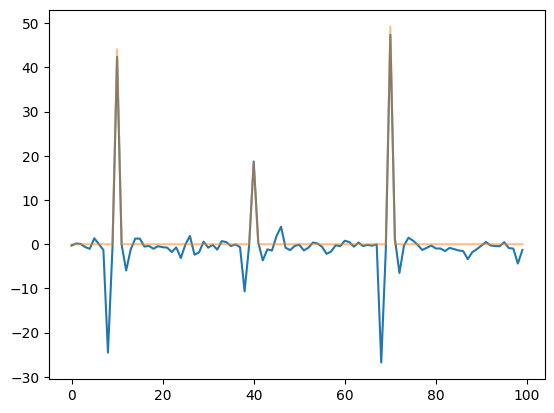

In [22]:
import matplotlib.pyplot as plt

wiener_new = wiener[4:]

plt.plot(wiener_new[5000:5100])
plt.plot(signal[5000:5100], alpha = 0.5)
plt.show()

In [49]:
# delatE of wiener filter

e_diff_wf = [i-j for i,j in zip(wiener_new, signal)]

Mean of the histogram:  -0.11590010314502878
Standard devistion: 0.8924036015307285
The range containing 98% of entries: (-1.98694096, 2.312772559999999)
Median of the range containing 98% of entries: -0.1980959999999996


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


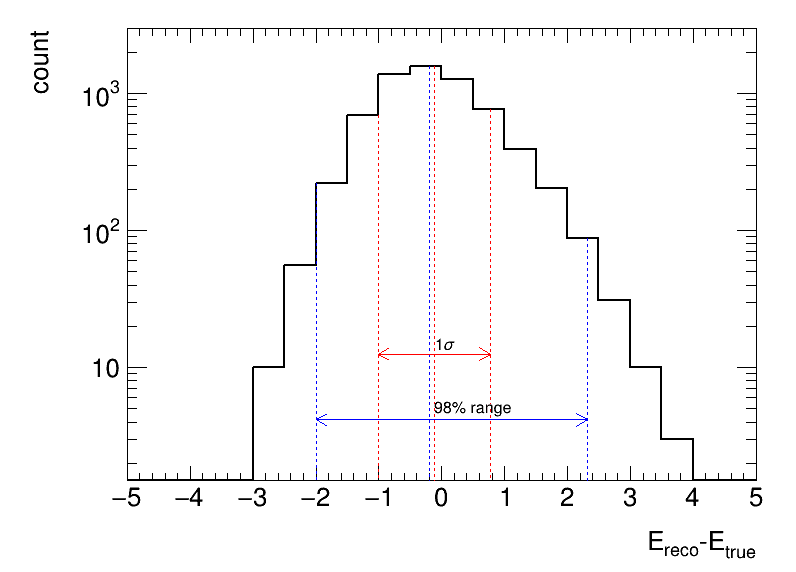

In [128]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(0, 10, bins = np.linspace(-5, 5, 21), e_diff=e_diff_wf)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

Mean of the histogram:  -0.2838545455231775
Standard devistion: 0.8825509114405391
The range containing 98% of entries: (-2.164272100000002, 2.153048879999997)
Median of the range containing 98% of entries: -0.3473600000000001


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


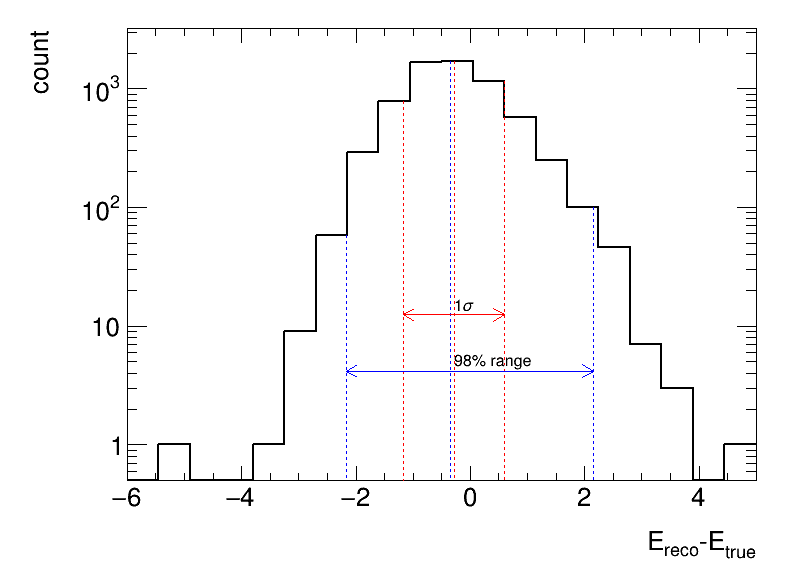

In [129]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(10, 20, bins = np.linspace(-6, 5, 21), e_diff=e_diff_wf)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

Mean of the histogram:  -0.458366625433176
Standard devistion: 0.8858874109124869
The range containing 98% of entries: (-2.3403064799999984, 1.9366896000000027)
Median of the range containing 98% of entries: -0.5164609999999996


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


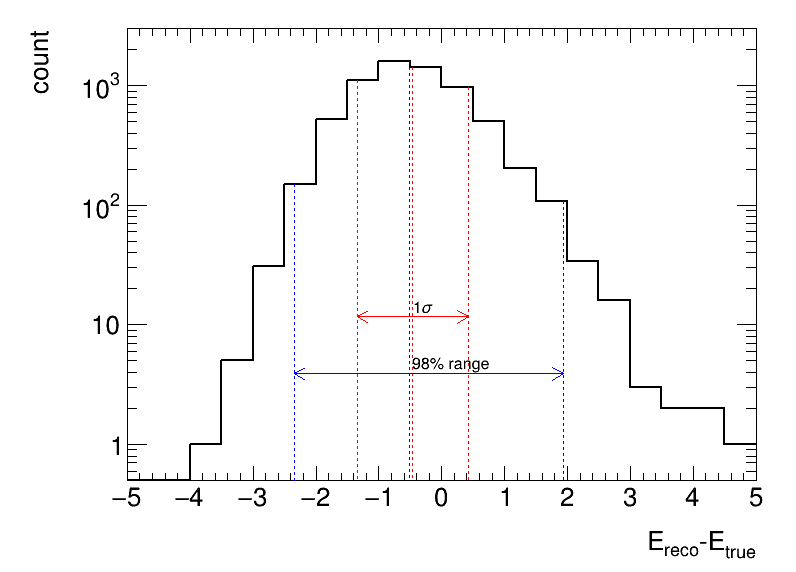

In [130]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(20, 30, bins = np.linspace(-5, 5, 21), e_diff=e_diff_wf)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

Mean of the histogram:  -0.6302430386554602
Standard devistion: 0.8891289404409001
The range containing 98% of entries: (-2.530898480000002, 1.70205904)
Median of the range containing 98% of entries: -0.691905000000002


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


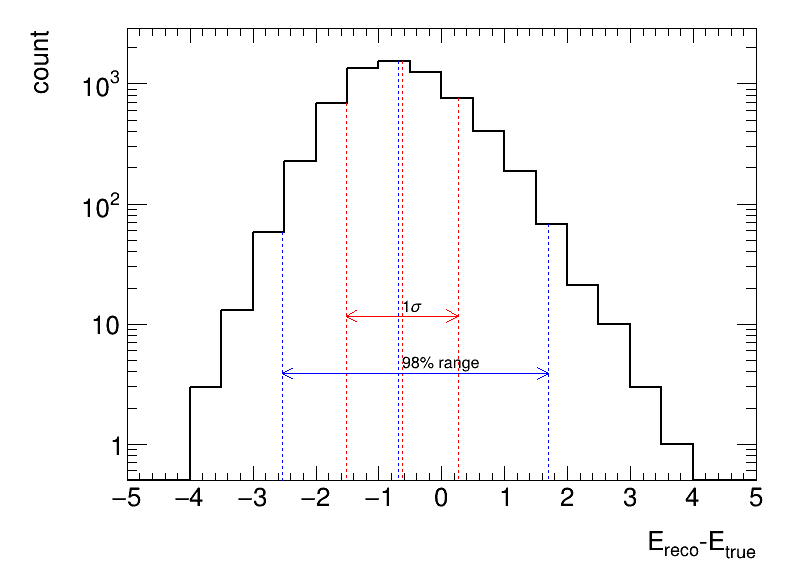

In [131]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(30, 40, bins = np.linspace(-5, 5, 21), e_diff=e_diff_wf)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

Mean of the histogram:  -0.806374899523668
Standard devistion: 0.8703125742101065
The range containing 98% of entries: (-2.6661448, 1.5670765599999972)
Median of the range containing 98% of entries: -0.8751834999999986


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


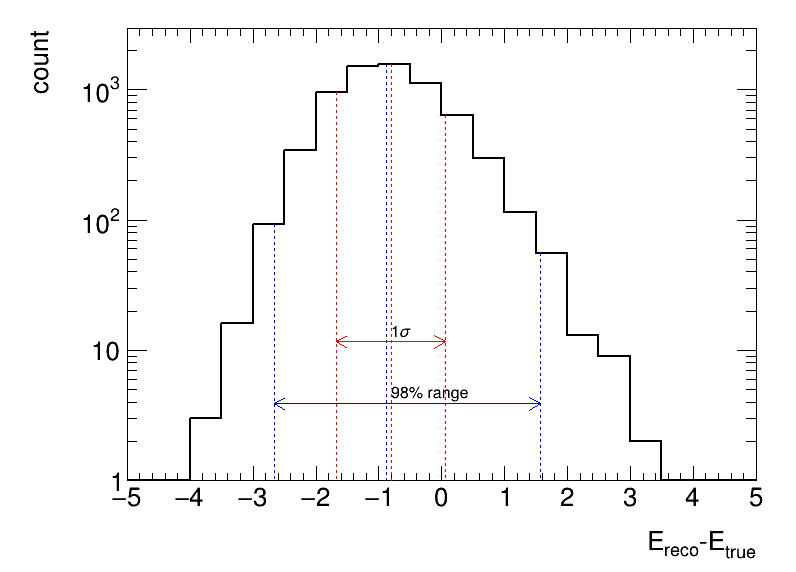

In [132]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)
hist, arr = plot_signal_range(40, 50, bins = np.linspace(-5, 5, 21), e_diff=e_diff_wf)
hist.Draw()
for l in arr:
    l.Draw()
canvas.SetLogy (1)
canvas.Update()
canvas.Draw()

In [226]:
bins = np.linspace(0, 50, 11)
e_diff = e_diff_wf
x, mean, std, median, lower_98, higher_98, indice = [], [], [], [], [], [], []


for j in range(len(bins)-1):
    x += [(bins[j] + bins[j+1])/2]
    indexs = [i for i in range(len(signal)) if signal[i] > bins[j] and signal[i] <= bins[j+1]]
    data = [e_diff[i] for i in indexs]
    indice += [len(indexs)]

    mean += [np.mean(data)]
    std += [np.std(data)]
    
    sorted_signal = np.sort(data)
    quantiles = np.percentile(sorted_signal, 1), np.percentile(sorted_signal, 99)
    filtered_signal = sorted_signal[(sorted_signal >= quantiles[0]) & (sorted_signal <= quantiles[1])]
    median += [np.median(filtered_signal)]
    lower_98 += [quantiles[0]]
    higher_98 += [quantiles[1]]

x_wf, mean_wf, std_wf, median_wf, lower_98_wf, higher_98_wf, indice_wf = x, mean, std, median, lower_98, higher_98, indice

In [176]:
# if add 0 entries

'''e_diff = e_diff_of

x_of += [0]
indexs = [i for i in range(len(signal)) if signal[i] == 0]
data = [e_diff[i] for i in indexs]
indice_of += [len(indexs)]
mean_of += [np.mean(data)]
std_of += [np.std(data)]

sorted_signal = np.sort(data)
quantiles = np.percentile(sorted_signal, 1), np.percentile(sorted_signal, 99)
filtered_signal = sorted_signal[(sorted_signal >= quantiles[0]) & (sorted_signal <= quantiles[1])]
median_of += [np.median(filtered_signal)]
lower_98_of += [quantiles[0]]
higher_98_of += [quantiles[1]]'''

In [177]:
# if add 0 entries

'''e_diff = e_diff_wf

x_wf += [0]
indexs = [i for i in range(len(signal)) if signal[i] == 0]
data = [e_diff[i] for i in indexs]
indice_wf += [len(indexs)]
mean_wf += [np.mean(data)]
std_wf += [np.std(data)]

sorted_signal = np.sort(data)
quantiles = np.percentile(sorted_signal, 1), np.percentile(sorted_signal, 99)
filtered_signal = sorted_signal[(sorted_signal >= quantiles[0]) & (sorted_signal <= quantiles[1])]
median_wf += [np.median(filtered_signal)]
lower_98_wf += [quantiles[0]]
higher_98_wf += [quantiles[1]]'''

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


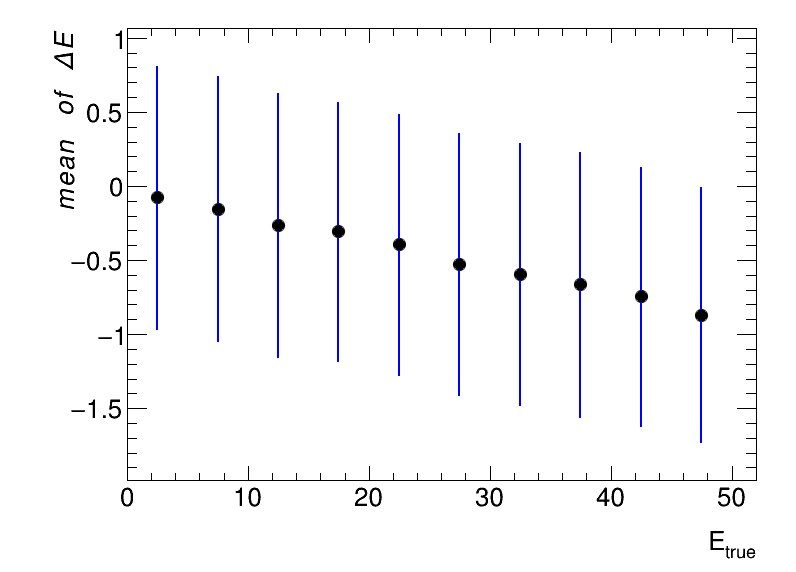

In [227]:
canvas = ROOT.TCanvas("canvas", "Graph Canvas", 800, 600)

x = x
y = mean
uncertainty_y = std

graph = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))

# Customize the graph appearance
graph.SetMarkerStyle(20)
graph.SetMarkerSize(1.5)
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)

# Set the axis titles
graph.GetXaxis().SetTitle("E_{true}")
graph.GetYaxis().SetTitle("mean\ of \overline{\Delta E}")
graph.GetYaxis().SetTitleOffset(1)

# Draw the graph
graph.Draw("AP")

# Update the canvas
canvas.Update()
canvas.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


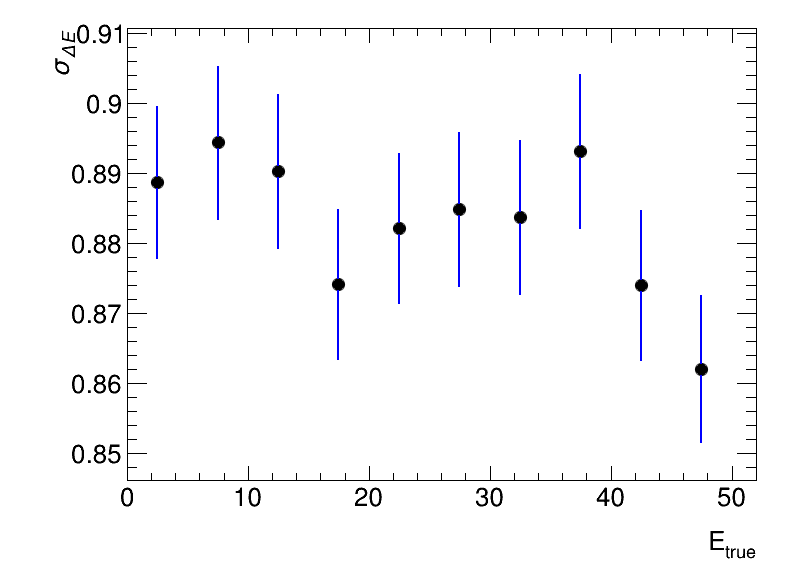

In [136]:
canvas = ROOT.TCanvas("canvas", "Graph Canvas", 800, 600)

x = x
y = np.array(std)
n = np.array(indice)
uncertainty_y = y / np.sqrt(2 * n-2)

graph = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))

# Customize the graph appearance
graph.SetMarkerStyle(20)
graph.SetMarkerSize(1.5)
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)

# Set the axis titles
graph.GetXaxis().SetTitle("E_{true}")
graph.GetYaxis().SetTitle("\sigma_{\Delta E}")
graph.GetYaxis().SetTitleOffset(1)

# Draw the graph
graph.Draw("AP")

# Update the canvas
canvas.Update()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


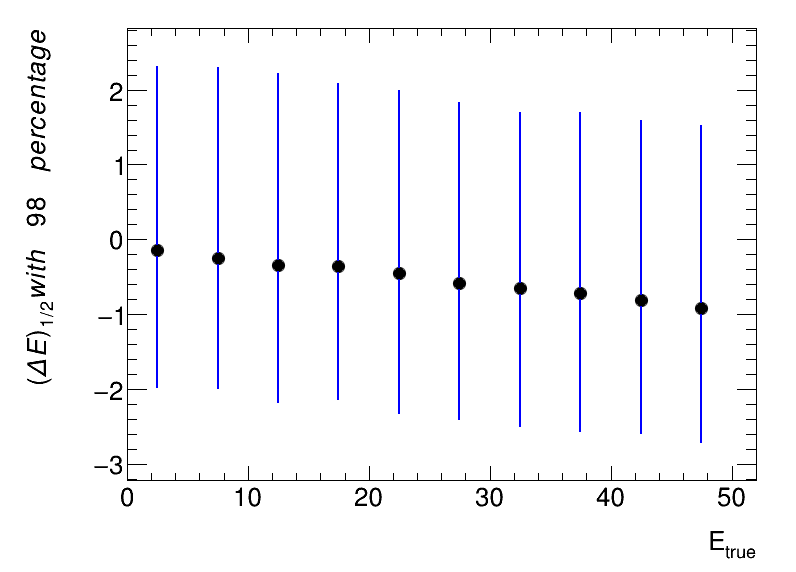

In [137]:
canvas = ROOT.TCanvas("canvas", "Histogram Canvas", 800, 600)

x = np.array(x, 'd')
y = np.array(median, 'd')
lower_error = np.array(lower_98, 'd')  
upper_error = np.array(higher_98, 'd')  


#graph = ROOT.TGraphErrors(len(x), x, y, np.zeros(len(x)), y_uncertainty)
graph = ROOT.TGraphAsymmErrors(len(x), x, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)


graph.SetMarkerStyle(20)
graph.SetMarkerSize(1.5)
graph.SetLineColor(ROOT.kBlue)
graph.SetLineWidth(2)

graph.GetXaxis().SetTitle("E_{true}")
graph.GetYaxis().SetTitle("(\Delta E)_{1/2} with\ 98\ percentage")

graph.Draw("AP")

canvas.Update()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


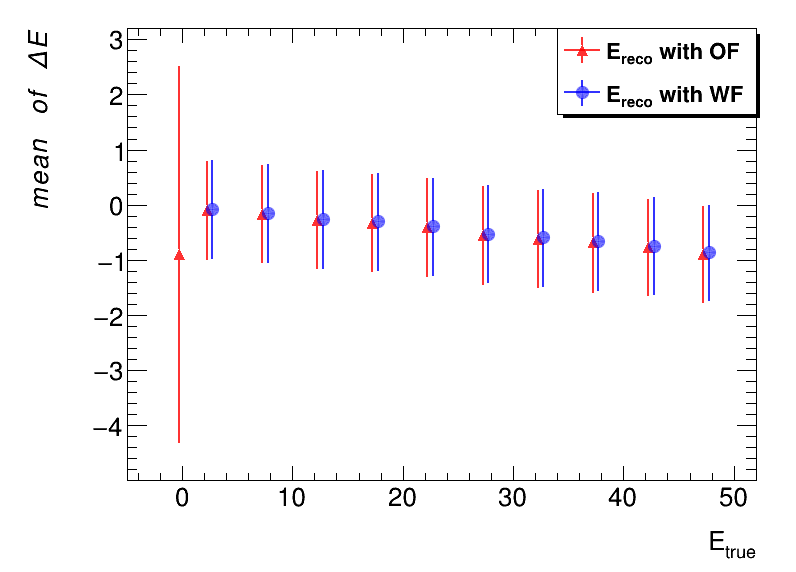

In [228]:
canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)


graph1 = ROOT.TGraphErrors(len(x_of), np.array(x_of, 'd')-0.25, np.array(mean_of, 'd'), np.zeros(len(x_of)), np.array(std_of, 'd'))
graph1.SetMarkerStyle(22)
graph1.SetMarkerSize(1.5)
graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
graph1.SetLineWidth(2)
graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

graph2 = ROOT.TGraphErrors(len(x_wf), np.array(x_wf, 'd')+0.25, np.array(mean_wf, 'd'), np.zeros(len(x_of)), np.array(std_wf, 'd'))
graph2.SetMarkerStyle(20)
graph2.SetMarkerSize(1.5)
graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
graph2.SetLineWidth(2)

graph1.GetXaxis().SetTitle("E_{true}")
graph1.GetYaxis().SetTitle("mean\ of \overline{\Delta E}")


legend = ROOT.TLegend(0.7, 0.8, 0.95, 0.95)
legend.AddEntry(graph1, "E_{reco} with OF", "lep")
legend.AddEntry(graph2, "E_{reco} with WF", "lep")

graph1.Draw("APE")
graph2.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


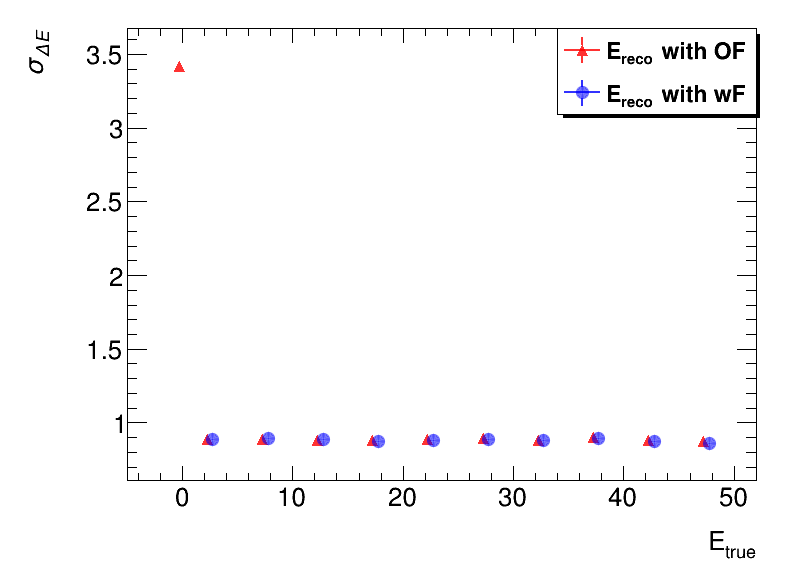

In [229]:
canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

y = np.array(std_of)
n = np.array(indice_of)
uncertainty_y = y / np.sqrt(2 * n-2)

graph1 = ROOT.TGraphErrors(len(x_of), np.array(x_of, 'd')-0.25, np.array(y, 'd'), np.zeros(len(x_of)), np.array(uncertainty_y, 'd'))
graph1.SetMarkerStyle(22)
graph1.SetMarkerSize(1.5)
graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
graph1.SetLineWidth(2)
graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)



y = np.array(std_wf)
n = np.array(indice_wf)
uncertainty_y = y / np.sqrt(2 * n-2)

graph2 = ROOT.TGraphErrors(len(x_wf), np.array(x_wf, 'd')+0.25, np.array(y, 'd'), np.zeros(len(x_wf)), np.array(uncertainty_y, 'd'))
graph2.SetMarkerStyle(20)
graph2.SetMarkerSize(1.5)
graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
graph2.SetLineWidth(2)

graph1.GetXaxis().SetTitle("E_{true}")
graph1.GetYaxis().SetTitle("\sigma_{\Delta E}")
#graph1.GetYaxis().SetRangeUser(0.85, 0.92)

legend = ROOT.TLegend(0.7, 0.8, 0.95, 0.95)
legend.AddEntry(graph1, "E_{reco} with OF", "lep")
legend.AddEntry(graph2, "E_{reco} with wF", "lep")

graph1.Draw("APE")
graph2.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


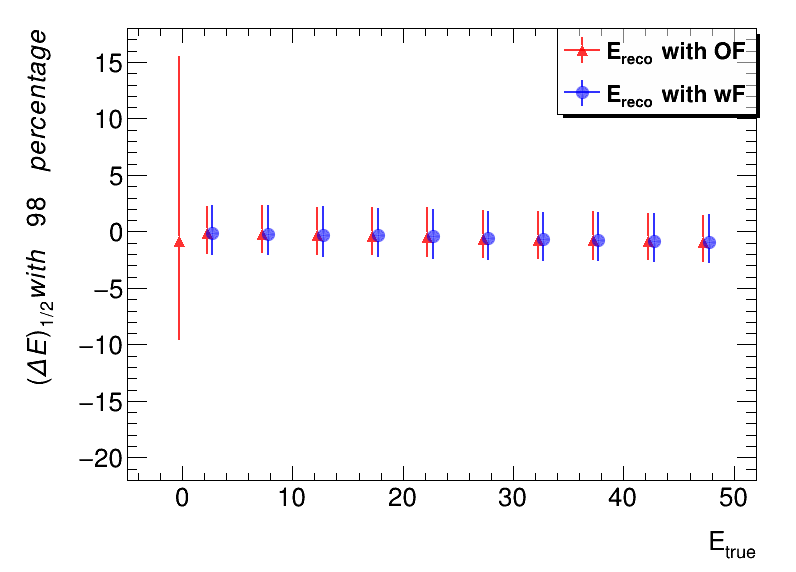

In [230]:
canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)


x = np.array(x_of, 'd')-0.25
y = np.array(median_of, 'd')
lower_error = np.array(lower_98_of, 'd')  
upper_error = np.array(higher_98_of, 'd')  

graph1 = ROOT.TGraphAsymmErrors(len(x), x, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)

graph1.SetMarkerStyle(22)
graph1.SetMarkerSize(1.5)
graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
graph1.SetLineWidth(2)
graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)


x = np.array(x_wf, 'd')+0.25
y = np.array(median_wf, 'd')
lower_error = np.array(lower_98_wf, 'd')  
upper_error = np.array(higher_98_wf, 'd')  

graph2 = ROOT.TGraphAsymmErrors(len(x), x, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)

graph2.SetMarkerStyle(20)
graph2.SetMarkerSize(1.5)
graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
graph2.SetLineWidth(2)

graph1.GetXaxis().SetTitle("E_{true}")
graph1.GetYaxis().SetTitle("(\Delta E)_{1/2} with\ 98\ percentage")
graph1.GetYaxis().SetRangeUser(-22,18)

legend = ROOT.TLegend(0.7, 0.8, 0.95, 0.95)
legend.AddEntry(graph1, "E_{reco} with OF", "lep")
legend.AddEntry(graph2, "E_{reco} with wF", "lep")
legend.SetFillColorAlpha(ROOT.kWhite, 0.5)

graph1.Draw("APE")
graph2.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
